## This notebook will walk you through cleaning up noisy V4 Miniscope data

Post questions or issues to the Miniscope Google Group: https://groups.google.com/g/miniscope

You will need the following packages installed (you likely should create a virtual python environment using conda or similar). You can use 'pip install <package name> 

* opencv-python
* numpy
* matplotlib
* tqdm
* scipy
* ipympl
* ipython

If a video is playing you can hit 'q' to quit the playback

- Aharoni Lab
- 09/18/2020


In [2]:
import os.path
from os import path
import cv2
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm 
from scipy.signal import butter, lfilter, freqz, filtfilt


# Need pip install ipympl
%matplotlib widget
plt.rcParams["figure.figsize"] = (10,5)

Enter the path to where your V4 Miniscope videos are saved.

In [3]:
# directory where videos are stored
dataDir = "/home/ckemere/Data"

# Data files should be .avi's and have the following form:
# '<dataDir><dataFilePrefix><startingFileNum>.avi'

# Values users can modify:
filename = '21-11-05-1450_scope_1.avi' # '22-04-01-1403_scope_'
max_frames = 25000
# -------------------------------

# TODO: Grab frames per file from metadate

data_file = os.path.join(dataDir,filename)
assert(os.path.exists(data_file))

We will now play back the video and calculate the mean 2D FFT of the played back frames. You can chage 'frameStep' to speed this up. We generally don't need tons of frames for calculating the mean 2D FFT of the video.

In [119]:
# Run through avi files and generate mean fft

# Values users can modify:
frameStep = 3 # Can use frame skipping to speed this up
showVideo = False

# -----------------------

sumFFT = None
running = True

cap = cv2.VideoCapture(data_file)
current_frame = -1
for frameNum in tqdm(range(0, max_frames, frameStep), total = max_frames/frameStep, 
                     desc ="Reading file: {}".format(data_file)):
    # OpenCV doesn't support skipping ahead well, so we'll read a frame at
    #   a time, and process only when the current_frame = the frame requested by tqdm
    #         cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
    while current_frame < frameNum:
        ret, _frame = cap.read()
        if (ret is False):
            break
        current_frame = current_frame + 1

    if (ret is False):
        break
    else:
        frame = _frame[:,:,1]
        
        dft_shift = np.fft.fftshift(np.fft.fft(wt, axis=-1))
#          dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT)
#         dft_shift = np.fft.fftshift(dft)

        if sumFFT is None:
            sumFFT = np.abs(dft_shift)
#             sumFFT = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
        else:
            sumFFT = sumFFT + np.abs(dft_shift)
#             sumFFT = sumFFT + cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])

        if (showVideo is True):
            cv2.imshow("Vid", frame/255)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                running = False
                break

cv2.destroyAllWindows()

Reading file: /home/ckemere/Data/21-11-05-1450_scope_1.avi:  85%|▊| 7044/8333.333333333334 [00:22<00:0


In [120]:
actual_total_frames = current_frame


In [180]:
len(masked_coeffs)

2

In [199]:
ax.shape

(4, 5)

38
38 38 1
76
76 76 2
152
152 152 5
304
304 304 10


/tmp/ipykernel_49471/1669884198.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(lev,3, figsize=(12,9))
/tmp/ipykernel_49471/1669884198.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig2, ax2 = plt.subplots(1,3)


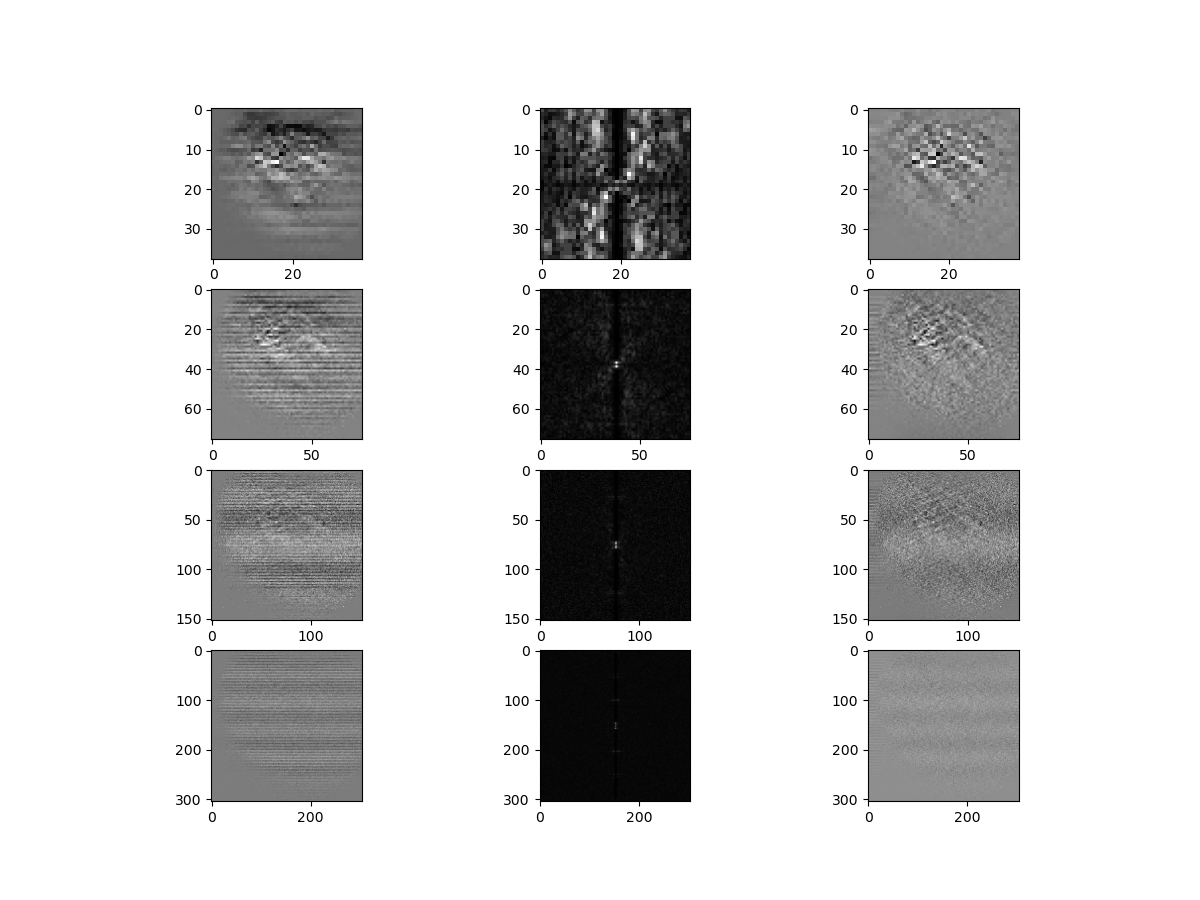

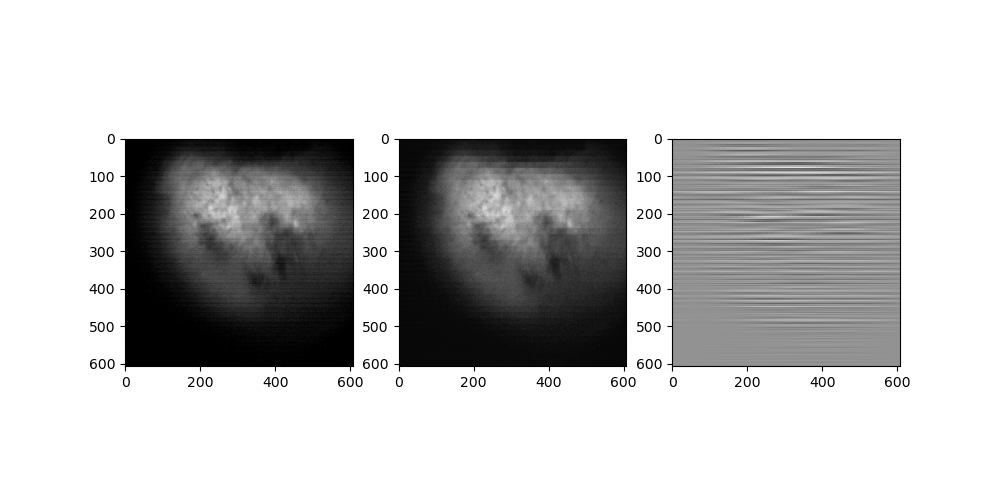

In [220]:
import pywt

lev = 4
coeffs = pywt.wavedec2(frame, 'haar', level=lev)

fig, ax = plt.subplots(lev,3, figsize=(12,9))
k = 5
rad = 20

masked_coeffs = []
masked_coeffs.append(coeffs[0])
# ax[0,0].imshow(coeffs[0], cmap='gray')
for i in range(lev):
    ax[i,0].imshow(coeffs[i+1][0], cmap='gray')
#     ax[i,1].imshow(coeffs[i+1][1], cmap='gray')
#     ax[i,2].imshow(coeffs[i+1][2], cmap='gray')
    
    d_stripe = coeffs[i+1][0]
    f_d = np.fft.fftshift(np.fft.fft2(d_stripe,))
    ax[i,1].imshow(np.abs(f_d), cmap='gray')

    _r, _c = d_stripe.shape
    print(_c)
    mask_rad = rad//(2**(lev-i))
    print(_r, _c, mask_rad)
    mid = _c//2
    col_mask = np.zeros((_r,_c), np.float32)
    col_mask[:,(mid-k):(mid+k+1)] += np.hamming(2*k+1) # ridge

    row_mask = np.ones((_r,_c), np.float32)
    row_mask[:,(mid-mask_rad):(mid+mask_rad+1)] -= np.hamming(2*mask_rad+1)
    
    fft_mask = 1 - (col_mask * row_mask.T)
    ax[i,1].imshow(np.abs(f_d * fft_mask), cmap='gray')

    masked_data = np.real(np.fft.ifft2(np.fft.ifftshift(f_d * fft_mask), ))
    ax[i,2].imshow(masked_data, cmap='gray')

    masked_coeffs.append([])
    masked_coeffs[i+1].append(masked_data)
    masked_coeffs[i+1].append(coeffs[i+1][1])
    masked_coeffs[i+1].append(coeffs[i+1][2])
    
recon = pywt.waverec2(masked_coeffs, 'haar')
fig2, ax2 = plt.subplots(1,3)
ax2[0].imshow(frame, cmap='gray')
ax2[1].imshow(recon, cmap='gray')
ax2[2].imshow(frame-recon, cmap='gray')


In [127]:
d.max(), d.min(), np.real(masked_d_1).max(), np.real(masked_d_1).min()

(55, 0, 1.0071082981587881e-14, -9.845371747091728e-15)

/tmp/ipykernel_49471/2135567060.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


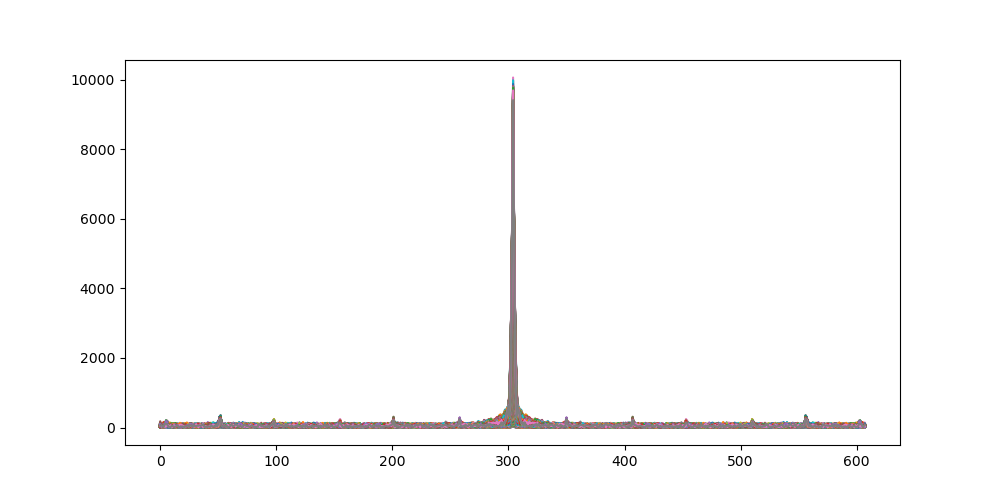

In [150]:
# f_1d = np.fft.fftshift(np.fft.fft(d, axis=-1))

plt.figure()
plt.plot(np.abs(np.fft.fftshift(np.fft.fft(d, axis=0))));
plt.show()
# plt.gca().set_xlim(290,320)

/tmp/ipykernel_49471/617174401.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(4,3, figsize=(12,12))


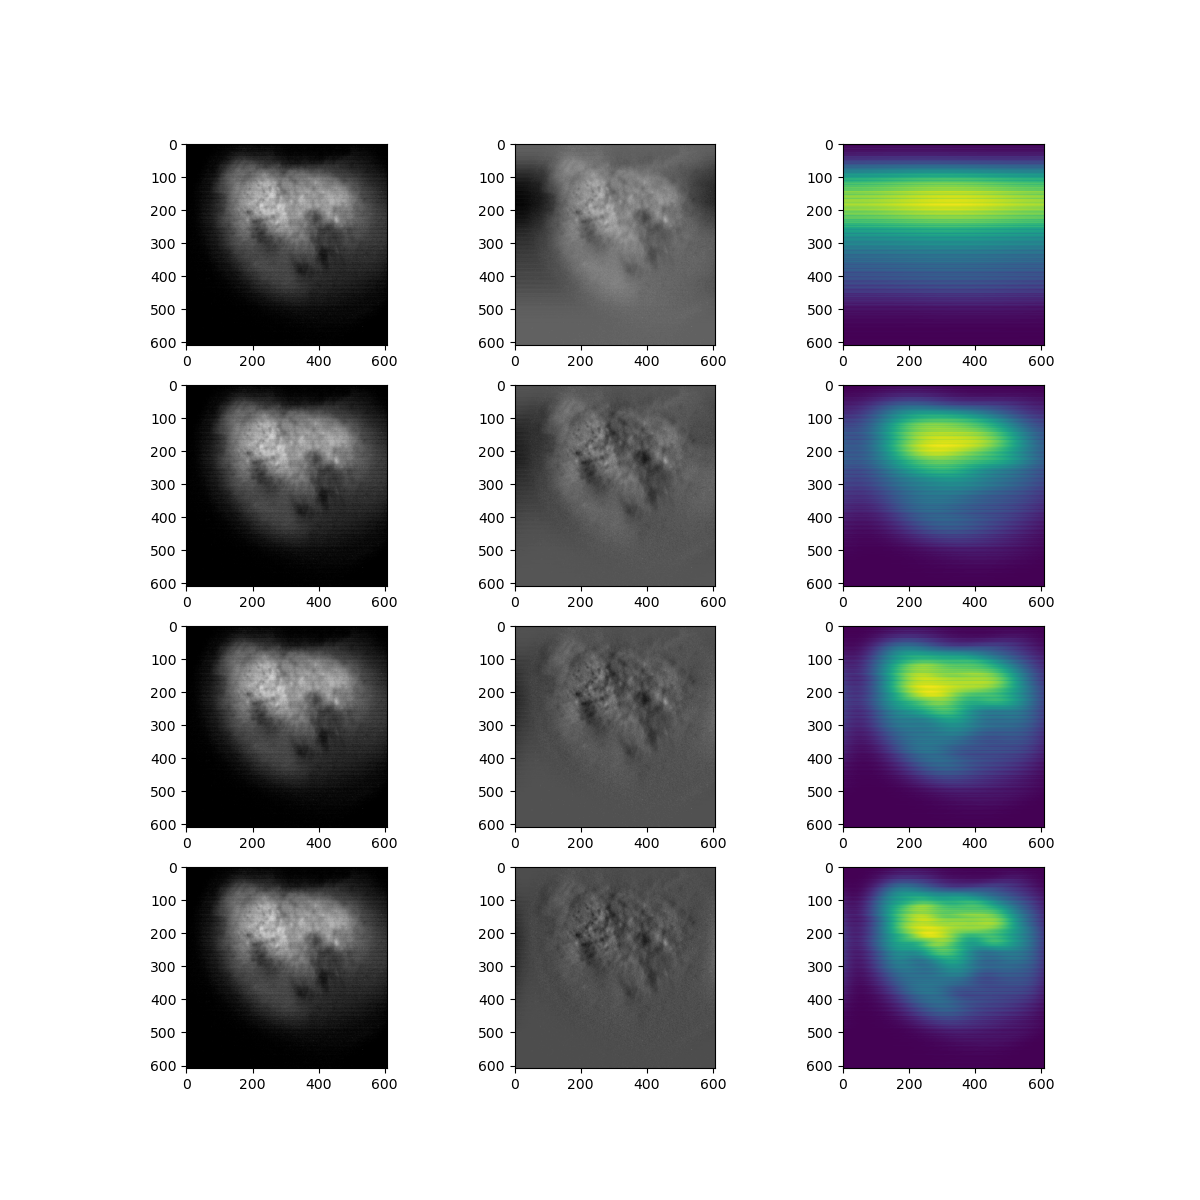

In [129]:
d = frame
_r, _c = d.shape
f_1d = np.fft.fftshift(np.fft.fft(d, axis=-1))

mid = _c//2


k = 1
fft_mask = np.ones((_r,_c), np.float32)
fft_mask[:,(mid-k):(mid+k+1)] -= np.hamming(2*k+1)


masked_d_1 = np.real(np.fft.ifft(np.fft.ifftshift(f_1d * fft_mask), ))
masked_d_1 = masked_d_1 - masked_d_1.min()

k = 3
fft_mask = np.ones((_r,_c), np.float32)
fft_mask[:,(mid-k):(mid+k+1)] -= np.hamming(2*k+1)
masked_d_3 = np.real(np.fft.ifft(np.fft.ifftshift(f_1d * fft_mask), ))
masked_d_3 = masked_d_3 - masked_d_3.min()

k = 5
fft_mask = np.ones((_r,_c), np.float32)
fft_mask[:,(mid-k):(mid+k+1)] -= np.hamming(2*k+1)
masked_d_5 = np.real(np.fft.ifft(np.fft.ifftshift(f_1d * fft_mask), ))
masked_d_5 = masked_d_5 - masked_d_5.min()

k = 7
fft_mask = np.ones((_r,_c), np.float32)
fft_mask[:,(mid-k):(mid+k+1)] -= np.hamming(2*k+1)
masked_d_7 = np.real(np.fft.ifft(np.fft.ifftshift(f_1d * fft_mask), ))
masked_d_7 = masked_d_7 - masked_d_7.min()


fig, ax = plt.subplots(4,3, figsize=(12,12))
ax[0,0].imshow(d, cmap='gray')
ax[0,1].imshow(masked_d_1, cmap='gray')
ax[0,2].imshow(d - masked_d_1)

ax[1,0].imshow(d, cmap='gray')
ax[1,1].imshow(masked_d_3, cmap='gray')
ax[1,2].imshow(d - masked_d_3)

ax[2,0].imshow(d, cmap='gray')
ax[2,1].imshow(masked_d_5, cmap='gray')
ax[2,2].imshow(d - masked_d_5)

ax[3,0].imshow(d, cmap='gray')
ax[3,1].imshow(masked_d_7, cmap='gray')
ax[3,2].imshow(d - masked_d_7)



We will now display the mean 2D FFT and show what sort of spatial filtering we want to apply. Generally the V4 Miniscope noise shows up as a vertical line with a few bright spots (these are the spatial frequencies related to the dim, scrolling horizontal stripes).

We want to filter these stripes out while not disturbing the actual imaging data. 

Below shows an example mean 2D FFT. Spatial frequencies due to the horizontal lines show up in the red boxes. The spatial frequencies in the green circle are mostly from the real data and you want to keep as much of this as possible while still removing most of the horizontal stripes.

<p align="center">
  <img width="300" src="img\2D-FFT-example.PNG">
</p>

Now we will display the raw, filtered, and difference video.

If things were done correctly, the filtered video show have the horizontal stripes removed and the difference video should pretty much only show those stripes (with maybe a tiny bit of other horizontal structure)

In [6]:
# Display filtered vs original videos

# Values users can modify:
frameStep = 3 # This will speed up the playback
# -----------------------

fileNum = startingFileNum
sumFFT = None
running = True

while (path.exists(dataDir + dataFilePrefix + "{:.0f}.avi".format(fileNum)) and running is True):
    cap = cv2.VideoCapture(dataDir + dataFilePrefix + "{:.0f}.avi".format(fileNum))
    fileNum = fileNum + 1
    lastFrameNum = 0
    
    for frameNum in tqdm(range(0,framesPerFile, frameStep), total = framesPerFile/frameStep, desc ="Running file {:.0f}.avi".format(fileNum - 1)):
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        while lastFrameNum <= frameNum:
            ret, frame = cap.read()
            if (ret is False):
                break
            lastFrameNum = lastFrameNum + 1        
        
        if (ret is False):
            break
        else:
            frame = frame[:,:,1]
            dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT|cv2.DFT_SCALE)
            dft_shift = np.fft.fftshift(dft)
             
            fshift = dft_shift * maskFFT
            f_ishift = np.fft.ifftshift(fshift)
            img_back = cv2.idft(f_ishift)
            img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
            
            img_back[img_back >255] = 255
            img_back = np.uint8(img_back)

            im_diff = (128 + (frame - img_back)*2)
            im_v = cv2.hconcat([frame, img_back, im_diff])
            cv2.imshow("Raw, Filtered, Difference", im_v/255)

            try:
                sumFFT = sumFFT + cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
            except:
                sumFFT = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])

            if cv2.waitKey(10) & 0xFF == ord('q'):
                running = False
                break

cv2.destroyAllWindows()

Running file 1.avi:  90%|███████████████████████████▊   | 597/666.6666666666666 [00:18<00:02, 32.21it/s]


Now we will correct the other source of V4 Miniscope noise. This is a fast, ~+3Hz fluctuation of the brightness of the entire field of view. 

* We will first run through the data and calculate the mean intensity of every frame.
* Next we will apply a lowpass filter to the mean intensity over time
* Finally we will scale the imaging data by the percentage difference of raw and filtered mean intensity.

In [44]:
# Calculate mean fluorescence per frame

# Users shouldn't change anything here
frameStep = 1 # Should stay as 1
fileNum = startingFileNum
sumFFT = None
meanFrameList = []

frame_data = []

while (path.exists(dataDir + dataFilePrefix + "{:.0f}.avi".format(fileNum))):
    cap = cv2.VideoCapture(dataDir + dataFilePrefix + "{:.0f}.avi".format(fileNum))
    fileNum = fileNum + 1
    lastFrameNum = 0
    for frameNum in tqdm(range(0,framesPerFile, frameStep), total = framesPerFile/frameStep, desc ="Running file {:.0f}.avi".format(fileNum - 1)):
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        while lastFrameNum <= frameNum:
            ret, frame = cap.read()
            if (ret is False):
                break
            lastFrameNum = lastFrameNum + 1     
        
        if (ret is False):
            break
        else:
            frame = frame[:,:,1]
            dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT|cv2.DFT_SCALE)
            dft_shift = np.fft.fftshift(dft)
             
            fshift = dft_shift * maskFFT
            f_ishift = np.fft.ifftshift(fshift)
            img_back = cv2.idft(f_ishift)
            img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
            meanFrameList.append(img_back.mean())
            
            frame_data.append(img_back)
            
            # clear_output(wait=True)

            # plt.subplot(121),plt.imshow(frame, cmap = 'gray')
            # plt.title('Input Image'), plt.xticks([]), plt.yticks([])
            # plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
            # plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

            # plt.show()
meanFrame = np.array(meanFrameList)

Running file 1.avi:  89%|███████████████████████████████████▊    | 1789/2000.0 [00:15<00:01, 116.34it/s]


Now we will generate a lowpass filter

In [30]:
# from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from scipy.sparse.linalg import svds

In [45]:
frame_data_m = np.array(frame_data)


In [67]:
T = len(frame_data)
dx, dy = frame_data[0].shape

In [118]:

# Find the decomposition of the first singular value of the movie.
# This should correspond to the flicker that we see!

u2, s2, v2 = svds(frame_data_m.reshape(T,dx*dy) - np.mean(frame_data,axis=0).reshape(1,dx*dy), k=1)

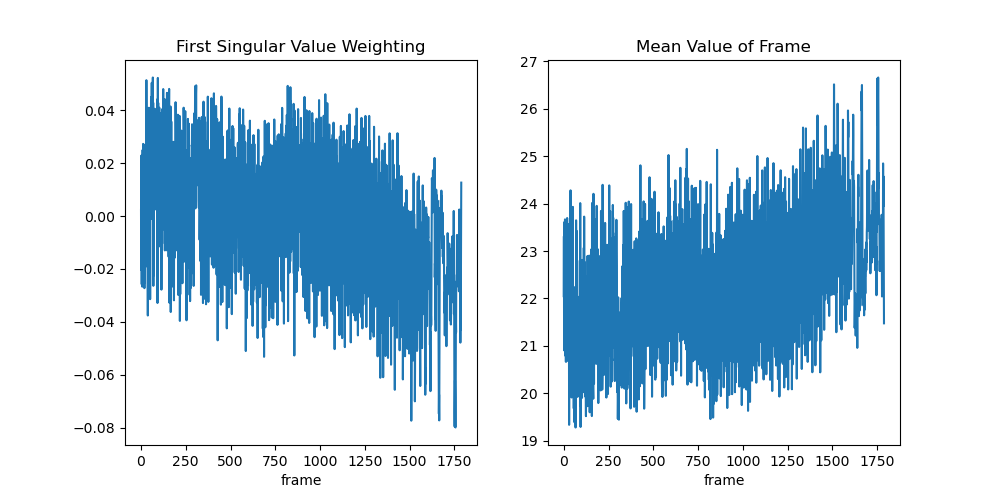

In [131]:
fig, ax = plt.subplots(1,2)
ax[0].plot(u2);
ax[0].set_title("First Singular Value Weighting")
ax[0].set_xlabel('frame')
ax[1].plot(meanFrame)
ax[1].set_title("Mean Value of Frame")
ax[1].set_xlabel('frame')
plt.show()

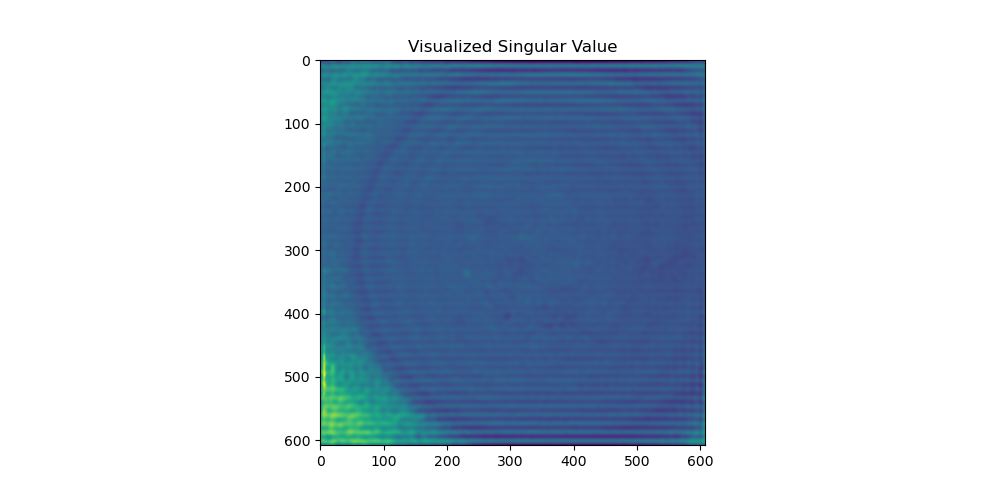

In [132]:
# Let's look at what is getting scaled - remember this is the SVD AFTER we've subtracted the mean
# Apparently the flickering is in some wierd cylindrical mode, presumably b/c of electrowetting lens?

fig, ax = plt.subplots(1,1)
ax.imshow(np.reshape(s2*v2,(dx,dy)))
ax.set_title('Visualized Singular Value')
plt.show()

Finally we will apply both the 2D FFT spatial filtering and the SVD intensity filtering to the raw data.

You can select between displaying the results and saving the results. If saving, the 'frameStep' should be set to 1.


In [129]:
# Apply FFT spatial filtering and lowpass filtering to data and has the option of saving as new videos

# Values users can modify:
# Select one below -
# mode = "display"
mode = 'save'

frameStep = 1 #1 # Should be set to 1 for saving

# Select one below -
compressionCodec = "FFV1"
# compressionCodec = "GREY"
# --------------------

fileNum = startingFileNum
sumFFT = None
frameCount = 0
running = True

if (mode is "save" and frameStep is not 1):
    print("WARNING: You are only saving every {} frame!".format(frameStep))

codec = cv2.VideoWriter_fourcc(compressionCodec[0],compressionCodec[1],compressionCodec[2],compressionCodec[3])

if (mode is "save" and not path.exists(dataDir + "Denoised")):
    os.mkdir(dataDir + "Denoised")

while (path.exists(dataDir + dataFilePrefix + "{:.0f}.avi".format(fileNum)) and running is True):
    cap = cv2.VideoCapture(dataDir + dataFilePrefix + "{:.0f}.avi".format(fileNum))

    if (mode is "save"):
        writeFile = cv2.VideoWriter(dataDir + "Denoised/" + dataFilePrefix + "denoised{:.0f}.avi".format(fileNum),  
                            codec, 60, (cols,rows), isColor=False) 

    fileNum = fileNum + 1
    lastFrameNum = 0
    for frameNum in tqdm(range(0,framesPerFile, frameStep), total = framesPerFile/frameStep, desc ="Running file {:.0f}.avi".format(fileNum - 1)):
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frameNum)
        while lastFrameNum <= frameNum:
            ret, frame = cap.read()
            if (ret is False):
                break
            lastFrameNum = lastFrameNum + 1     
        
        if (ret is False):
            break
        else:
            frame = frame[:,:,1]
            dft = cv2.dft(np.float32(frame),flags = cv2.DFT_COMPLEX_OUTPUT|cv2.DFT_SCALE)
            dft_shift = np.fft.fftshift(dft)
             
            fshift = dft_shift * maskFFT
            f_ishift = np.fft.ifftshift(fshift)
            img_back = cv2.idft(f_ishift)
            img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])
            
            svd_noise_model = np.reshape(u2[frameNum]*s2*v2, (dx, dy))
            img_back = img_back - svd_noise_model

            img_back[img_back >255] = 255
            img_back = np.uint8(img_back)


            if (mode is "save"):
                writeFile.write(img_back)

            if (mode is "display"):
                im_diff = (128 + (frame - img_back)*2)
                im_v = cv2.hconcat([frame, img_back])
                im_v = cv2.hconcat([im_v, im_diff])

                im_v = cv2.hconcat([frame, img_back, im_diff])
                cv2.imshow("Cleaned video", im_v/255)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    running = False
                    cap.release()
                    break

            frameCount = frameCount + 1

    if (mode is "save"):
        writeFile.release()

cv2.destroyAllWindows()


<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:66: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:80: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:20: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:25: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:31: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:66: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:80: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_25541/3143450080.py:20: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if (mode is "save" and frame